In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

train_set = pd.read_csv('train_set_modified.csv')
dev_set = pd.read_csv('dev_set.csv')
test_set = pd.read_csv('test.csv')

In [3]:
train_set.head()

,label-coarse,label-fine,text
0,0,0,How did serfdom develop in and then leave Russ...
1,1,1,What films featured the character Popeye Doyle ?
2,0,0,How can I find a list of celebrities ' real na...
3,1,2,What fowl grabs the spotlight after the Chines...
4,2,3,What is the full form of .com ?


In [3]:
# for train_set
train_set.loc[train_set['label-coarse'] > 4, 'label-coarse'] = 4

# for dev_set
dev_set.loc[dev_set['label-coarse'] > 4, 'label-coarse'] = 4

# for test_set
test_set.loc[test_set['label-coarse'] > 4, 'label-coarse'] = 4

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# neural network transforming the input for each word to its final vector representation
def token(sentence):

    # keep only english words
    sentence = re.sub("[^a-zA-Z]"," ",sentence)

    # converting to lower case and splitting

    # stop word removal
    words = sentence.split()
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_words)

    token = word_tokenize(filtered_sentence)
    return token

In [5]:
train_set['cleaned_text'] = train_set['text'].apply(token)
dev_set['cleaned_text'] = dev_set['text'].apply(token)
test_set['cleaned_text'] = test_set['text'].apply(token)

train_set.head()

,label-coarse,label-fine,text,cleaned_text
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]"
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]"
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]"
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]"
4,2,3,What is the full form of .com ?,"[full, form, com]"


In [6]:
# Function to get vocabulary
def get_vocab(data):
    vocab = set()
    for sentence in data:
        for word in sentence:
            vocab.add(word)
    word_to_ix = {word: i for i, word in enumerate(vocab)}
    return vocab, word_to_ix

In [7]:
import torch
# Function to pad sentences to max length
def pad(data, max_length):
    padded_data = []
    for sentence in data:
        if len(sentence) > max_length:
            padded_data.append(sentence[:max_length])
        else:
            padded_data.append(sentence + [' '] * (max_length - len(sentence)))
    return padded_data

max_length = max([len(sentence) for sentence in train_set['cleaned_text']])


In [8]:
train_set['padded_text'] = pad(train_set['cleaned_text'], max_length)
dev_set['padded_text'] = pad(dev_set['cleaned_text'], max_length)
test_set['padded_text'] = pad(test_set['cleaned_text'], max_length)

train_set.head()

,label-coarse,label-fine,text,cleaned_text,padded_text
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]","[serfdom, develop, leave, russia, , , , , ..."
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]","[films, featured, character, popeye, doyle, ,..."
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]","[find, list, celebrities, real, names, , , ..."
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]","[fowl, grabs, spotlight, chinese, year, monkey..."
4,2,3,What is the full form of .com ?,"[full, form, com]","[full, form, com, , , , , , , , , , ..."


In [9]:
vocab, word_to_ix = get_vocab(train_set['cleaned_text'])
word_to_ix[' '] = len(word_to_ix)
word_to_ix['<unk>'] = len(word_to_ix)
vocab.add(' ')
vocab.add('<unk>')

In [10]:
def aggregate(sentences, word_to_ix):
    data_ids = np.zeros([len(sentences), max_length], dtype=np.int64)
    for i in range(len(sentences)):
        for j in range(max_length):
            try:
                data_ids[i, j] = word_to_ix[sentences[i][j]]
            except:
                data_ids[i, j] = word_to_ix['<unk>']
    print(data_ids.shape)
    return torch.tensor(data_ids, dtype=torch.int64)

In [11]:
X_train = aggregate(train_set['padded_text'], word_to_ix)
y_train = torch.tensor(train_set['label-coarse'].values, dtype=torch.int64)
X_dev = aggregate(dev_set['padded_text'], word_to_ix)
y_dev = torch.tensor(dev_set['label-coarse'].values, dtype=torch.int64)
X_test = aggregate(test_set['padded_text'], word_to_ix)
y_test = torch.tensor(test_set['label-coarse'].values, dtype=torch.int64)

(4952, 18)
(500, 18)
(500, 18)


In [12]:
import torch.nn as nn

class WordRNNGRU(nn.Module):

    def __init__(self, vocab_size, hidden_dim, output_dim):
        super(WordRNNGRU, self).__init__()
        self.rnn = nn.GRU(vocab_size, hidden_dim, batch_first=True)
        self.dense = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, drop_rate):
        byte_vectors = nn.functional.one_hot(x, num_classes=vocab_size).float()
        encoding, _ = self.rnn(byte_vectors)
        encoding = encoding[:, -1, :]
        encoding = nn.functional.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
        return logits

seed = 10
np.random.seed(seed)
torch.manual_seed(seed)

In [13]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [14]:
from torch import optim
vocab_size = len(vocab)
hidden_dim = 128
output_dim = 5
model = WordRNNGRU(vocab_size, hidden_dim = hidden_dim, output_dim = output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper()

In [110]:
train_loss_list, train_accuracy_list = [], []
dev_loss_list, dev_accuracy_list = [], []
no_epochs = 31
for e in range(no_epochs):

    total_train_loss_per_epoch = []
    total_train_acc_per_epoch = []
    
    
    logits = model(X_train, drop_rate=0.3)
    loss = criterion(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = (logits.argmax(dim=1) == y_train).float().mean().item()
    # loss.append(loss.item()), acc.append(acc)
    total_train_loss_per_epoch.append(loss.item())
    total_train_acc_per_epoch.append(acc)

    model.eval()
    with torch.no_grad():
        total_dev_loss_per_epoch = []
        total_dev_acc_per_epoch = []
        dev_logits = model(X_dev, drop_rate=0)
        probs = nn.functional.softmax(dev_logits, dim=1)
        # print(probs)
        loss = criterion(dev_logits, y_dev)
        acc = (dev_logits.argmax(dim=1) == y_dev).float().mean().item()
        total_dev_loss_per_epoch.append(loss.item())
        total_dev_acc_per_epoch.append(acc)
    
    train_loss_list.append(np.mean(total_train_loss_per_epoch))
    train_accuracy_list.append(np.mean(total_train_acc_per_epoch))
    dev_loss_list.append(np.mean(total_dev_loss_per_epoch))
    dev_accuracy_list.append(np.mean(total_dev_acc_per_epoch))


    if e % 10 == 0:
        print(f'Epoch {e} | Train loss: {train_loss_list[-1]} | Train accuracy: {train_accuracy_list[-1]} | Dev loss: {dev_loss_list[-1]} | Dev accuracy: {dev_accuracy_list[-1]}') 
    
    if early_stopper.early_stop(dev_loss_list[-1]):
        print(f'Early stopping. Epoch {e} | Train loss: {train_loss_list[-1]} | Train accuracy: {train_accuracy_list[-1]} | Dev loss: {dev_loss_list[-1]} | Dev accuracy: {dev_accuracy_list[-1]}') 
        break

Epoch 0 | Train loss: 1.6390305757522583 | Train accuracy: 0.03857027366757393 | Dev loss: 1.6264069080352783 | Dev accuracy: 0.019999999552965164
Epoch 10 | Train loss: 1.5158133506774902 | Train accuracy: 0.30977383255958557 | Dev loss: 1.5013914108276367 | Dev accuracy: 0.335999995470047
Epoch 20 | Train loss: 1.4409995079040527 | Train accuracy: 0.31199514865875244 | Dev loss: 1.4432401657104492 | Dev accuracy: 0.335999995470047
Early stopping. Epoch 24 | Train loss: 1.4432605504989624 | Train accuracy: 0.2748384475708008 | Dev loss: 1.4484325647354126 | Dev accuracy: 0.335999995470047


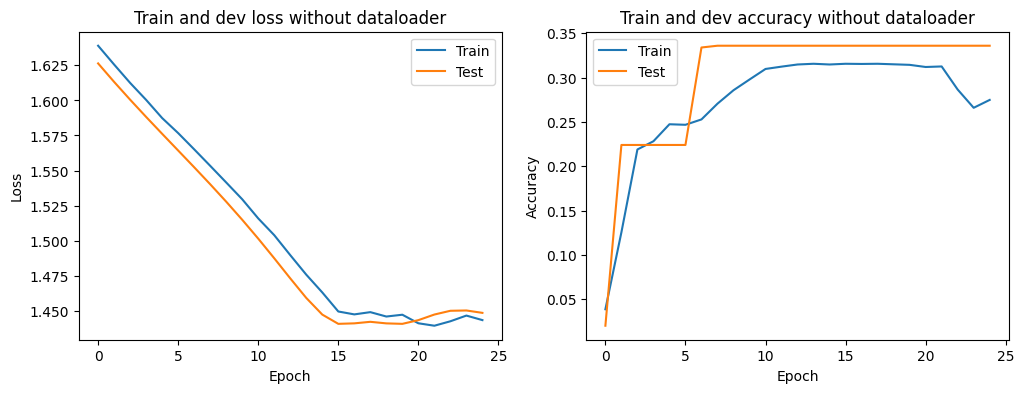

In [111]:
# Plot train and dev accurancies and losses on training and dev data against training epochs
num_epochs = len(train_loss_list)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Train and dev loss without dataloader')
plt.plot(range(num_epochs), train_loss_list, label='Train')
plt.plot(range(num_epochs), dev_loss_list, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Train and dev accuracy without dataloader')
plt.plot(range(num_epochs), train_accuracy_list, label='Train')
plt.plot(range(num_epochs), dev_accuracy_list, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
from torch.utils.data import DataLoader
batch_size = 32

train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(list(zip(X_dev, y_dev)), batch_size=batch_size, shuffle=True)

In [16]:
from torch import optim
vocab_size = len(vocab)
hidden_dim = 128
output_dim = 5
model = WordRNNGRU(vocab_size, hidden_dim = hidden_dim, output_dim = output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper()

In [18]:
train_loss_list, train_accuracy_list = [], []
dev_loss_list, dev_accuracy_list = [], []
no_epochs = 31
for e in range(no_epochs):

    total_train_loss_per_epoch = []
    total_train_acc_per_epoch = []
    
    model.train()
    for X_batch, y_batch in train_loader:
        logits = model(X_batch, drop_rate=0.3)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (logits.argmax(dim=1) == y_batch).float().mean().item()
        # loss.append(loss.item()), acc.append(acc)
        total_train_loss_per_epoch.append(loss.item())
        total_train_acc_per_epoch.append(acc)
    

    model.eval()
    with torch.no_grad():
        total_dev_loss_per_epoch = []
        total_dev_acc_per_epoch = []
        for X_batch, y_batch in dev_loader:
            dev_logits = model(X_batch, drop_rate=0)
            probs = nn.functional.softmax(dev_logits, dim=1)
            # print(probs)
            loss = criterion(dev_logits, y_batch)
            acc = (dev_logits.argmax(dim=1) == y_batch).float().mean().item()
            total_dev_loss_per_epoch.append(loss.item())
            total_dev_acc_per_epoch.append(acc)
    
    train_loss_list.append(np.mean(total_train_loss_per_epoch))
    train_accuracy_list.append(np.mean(total_train_acc_per_epoch))
    dev_loss_list.append(np.mean(total_dev_loss_per_epoch))
    dev_accuracy_list.append(np.mean(total_dev_acc_per_epoch))


    if e % 10 == 0:
        print(f'Epoch {e} | Train loss: {train_loss_list[-1]} | Train accuracy: {train_accuracy_list[-1]} | Dev loss: {dev_loss_list[-1]} | Dev accuracy: {dev_accuracy_list[-1]}') 
    
    if early_stopper.early_stop(dev_loss_list[-1]):
        print(f'Early stopping. Epoch {e} | Train loss: {train_loss_list[-1]} | Train accuracy: {train_accuracy_list[-1]} | Dev loss: {dev_loss_list[-1]} | Dev accuracy: {dev_accuracy_list[-1]}') 
        break

Epoch 0 | Train loss: 1.3389783044015207 | Train accuracy: 0.3600134409243061 | Dev loss: 0.9948578476905823 | Dev accuracy: 0.5714843757450581
Early stopping. Epoch 7 | Train loss: 0.04531890827140981 | Train accuracy: 0.9889112903225806 | Dev loss: 1.3144745863974094 | Dev accuracy: 0.7121093757450581


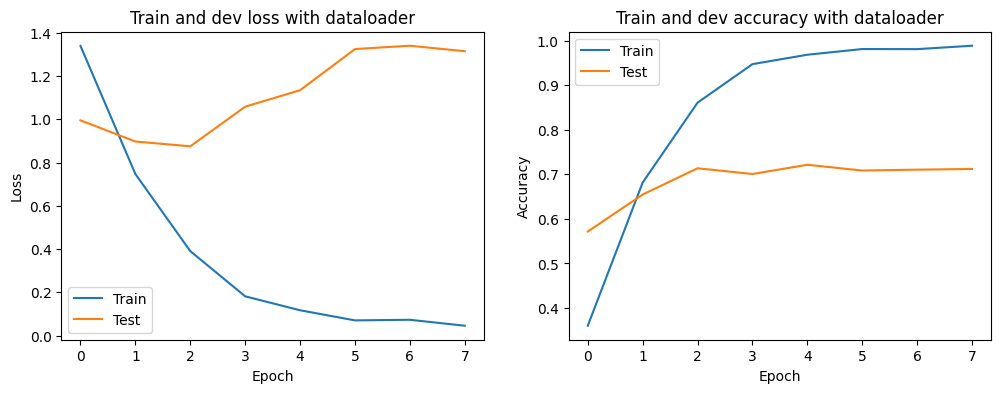

In [19]:
# Plot train and dev accurancies and losses on training and dev data against training epochs
num_epochs = len(train_loss_list)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Train and dev loss with dataloader')
plt.plot(range(num_epochs), train_loss_list, label='Train')
plt.plot(range(num_epochs), dev_loss_list, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Train and dev accuracy with dataloader')
plt.plot(range(num_epochs), train_accuracy_list, label='Train')
plt.plot(range(num_epochs), dev_accuracy_list, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
# Function to output predictions for test data
def predict(model, X_test):
    model.eval()
    with torch.no_grad():
        test_logits = model(X_test, drop_rate=0)
        probs = nn.functional.softmax(test_logits, dim=1)
        return probs.argmax(dim=1).numpy()

prediction = predict(model, X_test)
prediction


array([4, 4, 0, 0, 4, 4, 1, 2, 0, 0, 4, 3, 4, 3, 4, 4, 4, 3, 0, 4, 3, 0,
       4, 0, 0, 3, 1, 4, 1, 4, 4, 0, 0, 4, 3, 0, 4, 1, 4, 4, 1, 0, 0, 0,
       0, 1, 4, 0, 4, 1, 0, 3, 3, 0, 0, 2, 0, 4, 0, 0, 4, 1, 4, 1, 4, 4,
       1, 4, 4, 4, 4, 4, 4, 3, 4, 3, 1, 4, 4, 3, 0, 0, 3, 4, 4, 0, 0, 1,
       0, 4, 3, 0, 4, 4, 1, 4, 3, 0, 0, 3, 0, 3, 1, 3, 4, 0, 4, 4, 4, 4,
       0, 0, 4, 3, 0, 0, 0, 0, 4, 0, 4, 1, 0, 3, 4, 3, 4, 4, 1, 4, 4, 3,
       4, 4, 4, 4, 3, 3, 3, 0, 3, 1, 2, 3, 0, 1, 1, 4, 0, 0, 3, 3, 0, 4,
       3, 4, 4, 0, 1, 4, 0, 0, 4, 4, 3, 3, 4, 0, 4, 0, 4, 1, 4, 0, 0, 4,
       0, 4, 1, 4, 4, 0, 4, 0, 0, 3, 1, 0, 0, 4, 1, 4, 4, 3, 0, 4, 1, 3,
       1, 0, 3, 4, 1, 1, 4, 4, 3, 4, 0, 0, 4, 0, 4, 1, 0, 1, 0, 3, 4, 0,
       1, 4, 0, 3, 4, 0, 4, 0, 3, 3, 4, 3, 0, 4, 1, 0, 4, 0, 4, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 4, 1, 0, 0, 4, 1, 0, 4, 3, 3, 4, 1,
       0, 0, 0, 4, 4, 0, 1, 0, 0, 3, 0, 0, 0, 4, 2, 0, 1, 3, 2, 0, 1, 0,
       4, 0, 0, 1, 4, 1, 4, 1, 4, 0, 3, 4, 0, 1, 2,

In [21]:
prediction = pd.DataFrame(prediction)
prediction.columns = ['label-coarse']


,label-coarse
0,4
1,4
2,0
3,0
4,4


In [22]:
# Append the prediction to the test data
test_set['label-coarse'] = prediction['label-coarse']
test_set.head()

,label-coarse,label-fine,text,cleaned_text,padded_text
0,4,40,How far is it from Denver to Aspen ?,"[far, denver, aspen]","[far, denver, aspen, , , , , , , , , ..."
1,4,21,"What county is Modesto , California in ?","[county, modesto, california]","[county, modesto, california, , , , , , ..."
2,0,12,Who was Galileo ?,[galileo],"[galileo, , , , , , , , , , , , , ..."
3,0,7,What is an atom ?,[atom],"[atom, , , , , , , , , , , , , , ..."
4,4,8,When did Hawaii become a state ?,"[hawaii, become, state]","[hawaii, become, state, , , , , , , , ..."
